In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pylab as plt
import importlib
import matplotlib as mp
from numpy import exp
from mpl_toolkits.mplot3d import axes3d
from numpy import sqrt, arange, pi, meshgrid, cos, sin, mod, size, ones, zeros, linspace, floor, exp

import pickle

import pyafos

In [2]:
fig_width_pt = 4*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]


# params = {'backend': 'ps',
#           'axes.labelsize': 40,
#           'font.size': 40,
#           'legend.fontsize': 40,
#           'xtick.labelsize': 40,
#           'ytick.labelsize': 40,
#           'lines.linewidth': 6,
#           'text.usetex': True,
#           'figure.figsize': fig_size}

mp.rc('lines', lw=6)
mp.rc('savefig', format='pdf')
mp.rc('font', size = 40)
mp.rc('text', usetex = True)

In [3]:
#cotangent hyperbolic function
def coth(z):
    return (exp(z)+exp(-z))/(exp(z)-exp(-z))

#returns f = sum of amp*cos(omega*t+phase)
def periodic_f(t,freq,amp,phase):

    f = zeros(size(t))
    for i in range(size(freq)):
        f = f + cos(freq[i]*t + phase[i]) * amp[i]
        
    return f

##returns the points of the +- omega maps for each zero crossing in times
##returns the +map and the -map
def compute_maps(times, omega_p0, omega_m0, lamb):
    omega_p = np.zeros(size(times))
    omega_m = np.zeros(size(times))
    omega_p[0] = omega_p0
    omega_m[0] = omega_m0
    delta_t = np.diff(times)
    for idx, dt in enumerate(delta_t):
        omega_p[idx+1] = omega_p[idx] * exp(-lamb*dt) + pi
        omega_m[idx+1] = (pi + omega_m[idx]) * exp(-lamb*dt)
        
    return omega_p, omega_m

#returns the zeros of a periodic function
#the zeros within the period
#we assume freq[0] is the base frequency
def find_roots(t,freq,amp,phase):
    omegaF = freq[0]
    
    f = periodic_f(t, freq, amp, phase)
    ind = []
    for i in range(size(f)-1): 
        if(f[i]*f[i+1]<0):
            ind.append(i)
    return t[ind]

In [4]:
# function to create a subax
def create_subax(fig, ax, rect, xlimit=[], ylimit=[], xticks=[], yticks=[], side='b', xticklab=[], yticklab=[]):
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    sub_ax = fig.add_axes([x,y,width,height])
    
    if xlimit:
        sub_ax.set_xlim(xlimit)
    if ylimit:
        sub_ax.set_ylim(ylimit)

    for tick in sub_ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(30)
    for tick in sub_ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(30)

    
    sub_ax.set_xticks(xticks)
    sub_ax.set_yticks(yticks)
    if xticklab:
        sub_ax.set_xticklabels(xticklab)
    if yticklab:
        sub_ax.set_yticklabels(yticklab)
    
    if xlimit and ylimit:
        rect1 = mp.patches.Rectangle((xlimit[0],ylimit[0]), xlimit[1]-xlimit[0], ylimit[1]-ylimit[0], 
                                    color='k', fill=False, lw=2)
        ax.add_patch(rect1)
        transData = ax.transData.inverted()
        if side == 'b':
            subax_pos1 = transData.transform(ax.transAxes.transform(np.array(rect[0:2])+np.array([0,rect[3]])))
            subax_pos2 = transData.transform(ax.transAxes.transform(np.array(rect[0:2])+np.array([rect[2],rect[3]]))) 
            ax.plot([xlimit[0],subax_pos1[0]],[ylimit[0],subax_pos1[1]], color='k', lw=2)
            ax.plot([xlimit[1],subax_pos2[0]],[ylimit[0],subax_pos2[1]], color='k', lw=2)
        elif side == 'r':
            subax_pos1 = transData.transform(ax.transAxes.transform(np.array(rect[0:2])+np.array([0,rect[3]])))
            subax_pos2 = transData.transform(ax.transAxes.transform(np.array(rect[0:2]))) 
            ax.plot([xlimit[1],subax_pos1[0]],[ylimit[1],subax_pos1[1]], color='k', lw=2)
            ax.plot([xlimit[1],subax_pos2[0]],[ylimit[0],subax_pos2[1]], color='k', lw=2)
        elif side == 't':
            subax_pos1 = transData.transform(ax.transAxes.transform(np.array(rect[0:2])))
            subax_pos2 = transData.transform(ax.transAxes.transform(np.array(rect[0:2])+np.array([rect[2],0]))) 
            ax.plot([xlimit[0],subax_pos1[0]],[ylimit[1],subax_pos1[1]], color='k', lw=2)
            ax.plot([xlimit[1],subax_pos2[0]],[ylimit[1],subax_pos2[1]], color='k', lw=2)
    
    return sub_ax

num roots is  495


<IPython.core.display.Javascript object>


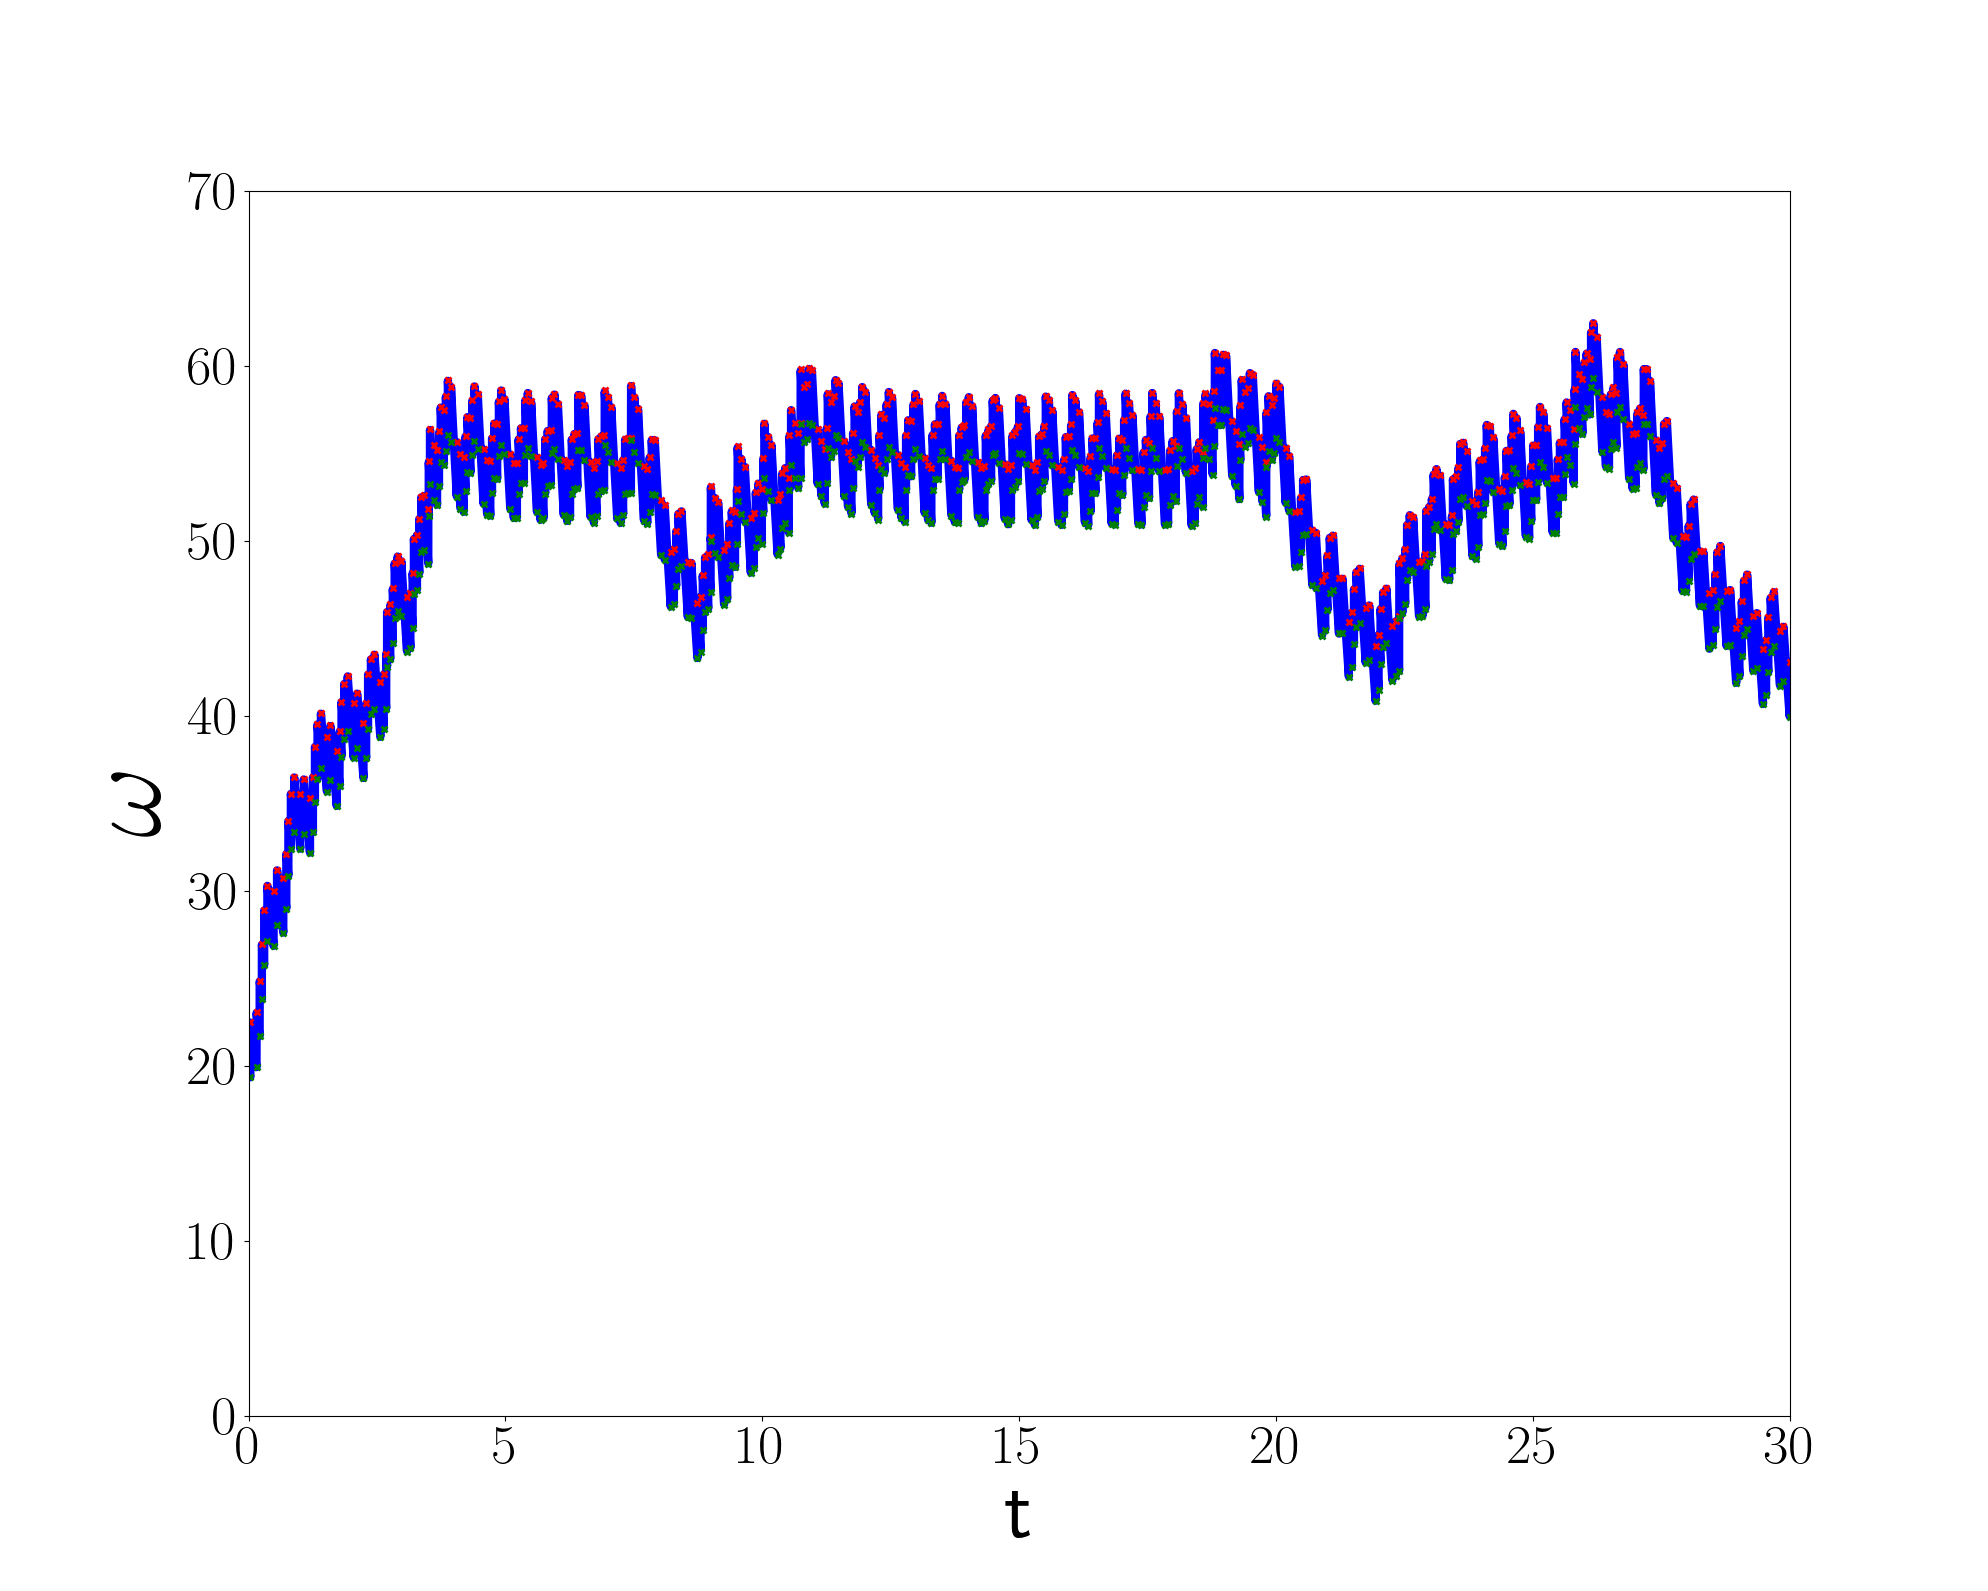

In [5]:
mp.rc('lines', lw=4)
mp.rc('font', size=60)
    
K = 10.**7
omegaF = 30.
freq = omegaF * np.array([1.,sqrt(2.),pi/sqrt(2.)])
amp = np.array([1.3,1.,1.4])
phase = np.array([0.,0.,0.])
lamb = 1
dt = 10**-8
save_dt = 10**-3
t_end = 30.
t_start = 0.
omega0 = 20./lamb
phi0 = 0.

#run an integration
oscill = pyafos.PhaseAFO()
oscill.initialize_vec(K,freq,amp,phase,lamb)
oscill.integrate(t_start,t_end,np.array([phi0,omega0]),dt,save_dt)

#generate data to be plotted    
t = oscill.t()
phi = oscill.y()[0,:]
omega = oscill.y()[1,:]

roots = find_roots(t, freq, amp, phase)
roots_corrected = roots + (2.*pi/omegaF - roots[-1])
n_roots = size(roots)
print('num roots is ',n_roots)
#print 'roots ', roots
#print 'roots corrected', roots_corrected

omega_p, omega_m = compute_maps(roots_corrected, omega0*exp(-lamb*roots[0])+pi, omega0*exp(-lamb*roots[0]), lamb)    

#plot stuff
fig = plt.figure(1)

m = plt.get_current_fig_manager()
m.resize(1591, 1273)

fig.set_size_inches([ 19.8875,  15.9125])

#axes 1
ax2 = fig.add_subplot(111)
ax2.set_xlim([0,t_end])
ax2.set_ylim([0,70])
ax2.set_xlabel('t')
ax2.set_ylabel(r'$\displaystyle \omega$', size=80)

for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(40)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(40)

#     ax2_subax1 = create_subax(fig, ax2, [0.67,0.1,0.3,0.5], 
#                               xlimit=[6.5,6.9], ylimit=[60-4,60+4],
#                               xticks=[6.5,6.7,6.9], yticks=[60-3,60,60+3], side='b',
#                               )
#     ax2_subax2 = create_subax(fig, ax2, [0.25,0.1,0.3,0.5], 
#                               xlimit=[0.15,0.55], ylimit=[25,37],
#                               xticks=[0.2,0.35,0.5], yticks=[25,30,35], side='r',
#                               )
#     axes_plot = [ax2, ax2_subax1, ax2_subax2]
axes_plot = [ax2]

for a in axes_plot:
    if a == ax2:
        mw = 2.0
        ms = 4.0
    else:
        mw = 4.0
        ms = 10.0

        #plot cos = 0
        tx = arange((pi/2)/omegaF,t_end,pi/omegaF   )
        for i in tx:
            a.plot([i,i],[0,110],ls=':',lw=2,color='k')

    a.plot(t, lamb*omega, color='b', lw=6, ls='-')                    
    a.plot(roots, lamb*omega_p, ls='', marker='x', markeredgewidth=mw, markersize=ms, color='r')
    a.plot(roots, lamb*omega_m, ls='', marker='x', markeredgewidth=mw, markersize = ms, color='g')


# Plot invariant manifolds in 2D

<IPython.core.display.Javascript object>


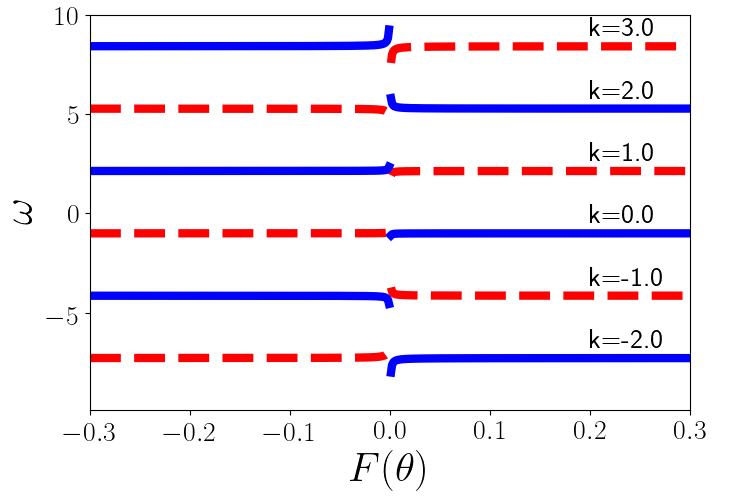

In [6]:
mp.rc('lines', lw=6)

epsilon = 0.0001

lambd = 1
theta_m = arange(-0.3, -0.0005, 0.001)
theta_p = arange(0.001, 0.3, 0.001)
Om = 1.0 #arange(-9.9,9.9,0.05)

mp.rc('font', size=20)
mp.rc('ytick', labelsize = 20)
mp.rc('xtick', labelsize = 20)


fig = plt.figure()
ax = fig.add_subplot(1,1,1)

k_range = arange(-2.,4,1) 


def invariant_k(k,ax):
    omega_p = (k*pi-Om)*(1+epsilon*((-1.)**k)*lambd/theta_p) 
    omega_m = (k*pi-Om)*(1+epsilon*((-1.)**k)*lambd/theta_m)
    if k%2==0: ##if k is even then F(theta)>0 for stable manifolds
#             print ((-1)**(k+1)*cos(omegaF*theta1p)).min()
#             print ((-1)**(k+1)*cos(omegaF*theta1p)).max()
        ax.plot(theta_p, omega_p, color='b', lw = 6) #stable
        ax.plot(theta_m, omega_m, color='r', lw = 6,ls='--') #unstable
    else:
        ax.plot(theta_p, omega_p, color='r', lw = 6,ls='--') #unstable
        ax.plot(theta_m, omega_m, color='b', lw = 6) #stable

    ax.text(0.2, omega_p[-1]+0.5,'k={0}'.format(k))

for k_var in k_range:
    invariant_k(k_var,ax)

plt.xlim(-0.3,0.3)
plt.ylim(-9.9,10)

#put the text    
plt.ylabel(r'$\displaystyle \omega$', fontsize=30)
plt.xlabel(r'$\displaystyle F(\theta)$', fontsize=30)


#tune the view
m = plt.get_current_fig_manager()
m.resize(1591, 1273)

plt.subplots_adjust(left=0.12, bottom=0.18, top=0.97, right=0.92)

fig.set_size_inches([ 7.5,  5.])


# Plot invariant manifold in 3D

In [ ]:
mp.rc('font', size = 40)
mp.rc('lines', lw=6)

epsilon = 0.0001

lambd = 1
theta_m = arange(-1.0, -0.01, 0.01)
theta_p = arange(0.01, 1.0, 0.01)
Om = arange(-9.9,9.9,0.05)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

k_range = arange(0,10,1) 

def invariant_k(k,ax):
    theta1p, Om1p = meshgrid(theta_p,Om)
    theta1m, Om1m = meshgrid(theta_m,Om)
    omega_p = (k*pi-Om1p)*(1+epsilon*((-1)**k)*lambd/theta1p) 
    omega_m = (k*pi-Om1m)*(1+epsilon*((-1)**k)*lambd/theta1m)
    if k%2==0: ##if k is even then F(theta)>0 for stable manifolds
#             print ((-1)**(k+1)*cos(omegaF*theta1p)).min()
#             print ((-1)**(k+1)*cos(omegaF*theta1p)).max()
        ax.plot_surface(theta1p, Om1p, omega_p, color='b', edgecolors='b') #stable
        ax.plot_surface(theta1m, Om1m, omega_m, color='r', edgecolors='r') #unstable
    else:
        ax.plot_surface(theta1p, Om1p, omega_p, color='r', edgecolors='r') #unstable
        ax.plot_surface(theta1m, Om1m, omega_m, color='b', edgecolors='b') #stable


for k_var in k_range:
    invariant_k(k_var,ax)

ax.set_xlim3d(-1,1)
ax.set_ylim3d(Om[0], Om[-1])
#     ax.set_zlim3d(-19, 5);


#put the text    
ax.text(1.35, 10.9, 16.0, r'$\displaystyle \omega$', zdir=None, fontsize=40)
ax.text(-0.3, -12, -27.0, r'$\displaystyle F(\theta)$', zdir=None, fontsize=40)
ax.text(1.4, 1.2, -16.0, r'$\displaystyle \Omega$', zdir=None, fontsize=40)


#tune the view
ax.azim = -74
ax.elev = 28

m = plt.get_current_fig_manager()
m.resize(1591, 1273)

fig.set_size_inches([ 9.5,  7.5])   
        




# generate AFO data for periodic input

In [6]:
K = 10.**7
omegaF = 100.
lamb = 1.
dt = 10**-7
save_dt = 10**-4
t_end = 6.
t_start = 0.
omega0 = 20./lamb
phi0 = 0.


#run an integration
oscill = afos.PhaseAFO()
oscill.initialize_vec(K,np.array([omegaF]),np.array([1.0]),np.array([0.0]),lamb)
oscill.integrate(t_start,t_end,np.array([phi0,omega0]),dt,save_dt)

#generate data to be plotted    
t = oscill.t()
phi = oscill.y()[0,:]
omega = oscill.y()[1,:]

#save data to file


# plot AFO with periodic input

In [8]:
mp.rc('lines', lw=4)
mp.rc('font', size=60)



omega_bar_p = pi / (1 - exp(-lamb*pi/omegaF))
omega_bar_m = pi / (exp(lamb*pi/omegaF) - 1)
omega_bar_avg = 0.5*(omega_bar_p + omega_bar_m)

print(omega_bar_avg)

tn = arange(0,t_end,pi/omegaF)
omega_p = (omega[(np.abs(t-pi/omegaF/2)).argmin()]+pi - omega_bar_p)*exp(-lamb * tn) + omega_bar_p
omega_m = (omega[(np.abs(t-pi/omegaF/2)).argmin()] - omega_bar_m)*exp(-lamb * tn) + omega_bar_m
omega_avg = (omega0 -omega_bar_avg) * exp(-lamb*t) + omega_bar_avg

phi_m = zeros(size(tn))
phi_m[0] = phi[(np.abs(t-pi/omegaF/2)).argmin()]
for i in range(1,size(tn)):
    phi_m[i] = phi_m[i-1] + pi
phi_p = phi_m+pi

#plot stuff
fig = plt.figure()

m = plt.get_current_fig_manager()
m.resize(1591, 1273)

fig.set_size_inches([ 19.8875,  15.9125])

#axes 1
ax1 = fig.add_subplot(211)
ax1.set_xlim([0, t_end])
ax1.set_ylim([-10, 650])
ax1.set_ylabel(r'$\displaystyle \phi$', size=80)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(40)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(40)

ax1_subax1 = create_subax(fig, ax1, [0.68,0.1,0.3,0.5], 
                          xlimit=[5.55,5.75], ylimit=[550,580],
                          xticks=[5.6,5.7], yticks=[550,560,570], side='b',
                          )

ax1_subax2 = create_subax(fig, ax1, [0.05,0.49,0.3,0.5], 
                          xlimit=[0.15,0.35], ylimit=[10,40],
                          xticks=[0.2,0.3], yticks=[15,25,35], side='t',
                          )
axes_plot = [ax1, ax1_subax1, ax1_subax2]
for a in axes_plot:
    if a == ax1:
        mw = 2.0
        ms = 4.0
    else:
        mw = 4.0
        ms = 10.0

        #plot cos = 0
        tx = arange((pi/2)/omegaF,t_end,pi/omegaF   )
        for i in tx:
            a.plot([i,i],[0,650],ls=':',lw=2,color='k')

    a.plot(t, phi, color='b', lw=6, ls='-')
    a.plot(tn+pi/omegaF/2+0.0005, phi_p, ls='', marker='x', markeredgewidth=mw, markersize=ms, color='r')
    a.plot(tn+pi/omegaF/2, phi_m, ls='', marker='x', markeredgewidth=mw, markersize=ms, color='g')


ax2 = fig.add_subplot(212)
ax2.set_xlim([0,t_end])
ax2.set_ylim([-10,110])
ax2.set_xlabel('t')
ax2.set_ylabel(r'$\displaystyle \omega$', size=80)

for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(40)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(40)

ax2_subax1 = create_subax(fig, ax2, [0.67,0.1,0.3,0.5], 
                          xlimit=[5.55,5.75], ylimit=[omega_bar_avg-3,omega_bar_avg+2.5],
                          xticks=[5.6,5.7], yticks=[100-3,100,100+3], side='b',
                          )
ax2_subax2 = create_subax(fig, ax2, [0.2,0.1,0.3,0.5], 
                          xlimit=[0.15,0.35], ylimit=[27,47],
                          xticks=[0.2,0.3], yticks=[30,35,40,45], side='r',
                          )
axes_plot = [ax2, ax2_subax1, ax2_subax2]

for a in axes_plot:
    if a == ax2:
        mw = 2.0
        ms = 4.0
    else:
        mw = 4.0
        ms = 10.0

        #plot cos = 0
        tx = arange((pi/2)/omegaF,t_end,pi/omegaF   )
        for i in tx:
            a.plot([i,i],[0,110],ls=':',lw=2,color='k')

    if a == ax2_subax1:
        a.plot(t, omega_bar_avg*np.ones(size(t)), ls='-.',lw=4,color='k')

    a.plot(t, lamb*omega, color='b', lw=6, ls='-')                    
    a.plot(tn+pi/omegaF/2+0.0005, lamb*omega_p, ls='', marker='x', markeredgewidth=mw, markersize=ms, color='r')
    a.plot(tn+pi/omegaF/2, lamb*omega_m, ls='', marker='x', markeredgewidth=mw, markersize = ms, color='g')
    a.plot(t, lamb*omega_avg, ls='--',lw=4, color='k')

100.00822453504696


<IPython.core.display.Javascript object>

In [ ]:
def plot_afo_3periodic():
    mp.rc('lines', lw=4)
    mp.rc('font', size=60)
    
    K = 10.**6
    omegaF = 30.
    freq = omegaF * np.array([1.,2.,3.])
    amp = np.array([1.3,1.,1.4])
    phase = np.array([0.4,0.,1.3])
    lamb = 1
    dt = 10**-7
    save_dt = 10**-3
    t_end = 8.
    t_start = 0.
    omega0 = 20./lamb
    phi0 = 0.
    
    #run an integration
    res = afos.integrate_afo(t_start,t_end,K,lamb,np.array([phi0,omega0]),
                             freq,amp,phase,dt,save_dt)

    #generate data to be plotted    
    t = res[0,:]
    phi = res[1,:]
    omega = res[2,:]

    deltaT = np.linspace(0.0,2*pi/omegaF,10000)
    roots = find_roots(deltaT, freq, amp, phase)
    roots_corrected = roots + (2.*pi/omegaF - roots[-1])
    n_roots = size(roots)
    print('num roots is ', n_roots)
    print('roots ', roots)
    print('roots corrected', roots_corrected)

#     omega_bar_p = omegaF * n_roots * (0.5 / lamb) + pi + omegaF * 0.5 * sum(roots[:-1])
#     omega_bar_m = omegaF * n_roots * (0.5 / lamb) + omegaF * 0.5 * sum(roots[:-1])
#     omega_bar_avg = omegaF * n_roots * (0.5 / lamb) + pi*0.5 + omegaF * 0.5 * sum(roots[:-1])
    omega_bar_p = pi / (exp(lamb*2*pi/omegaF)-1) * (sum(exp(lamb*roots_corrected)))
    omega_bar_m = pi / (exp(lamb*2*pi/omegaF)-1) * (1 + sum(exp(lamb*roots_corrected[:-1])))
    omega_bar_avg = pi / (2*(exp(lamb*2*pi/omegaF)-1)) * (1 + exp(lamb*2*pi/omegaF) + 2*sum(exp(lamb*roots_corrected[:-1])))

    print('omega_bar o+ and o-', omega_bar_avg * lamb, omega_bar_p, omega_bar_m)
    
    print('approx omega_bar ', omegaF * n_roots/2 + lamb * pi / 2. + omegaF/2. * sum(lamb*roots_corrected[:-1]))
    
    tn = np.array([])
    for i in range(int(t_end / (2*pi/omegaF))+1):
        tn = np.append(tn, i*2*pi/omegaF + roots)
    omega_p, omega_m = compute_maps(tn, omega0*exp(-lamb*roots[0])+pi, omega0*exp(-lamb*roots[0]), lamb)
    print('omega_p omega_m', omega_p[-4:], omega_m[-4:])
    omega_avg = (omega0 -n_roots/2.*omegaF) * exp(-lamb*t) + n_roots/2.*omegaF
    tn = tn
    #plot stuff
    fig = plt.figure(1)
    
    m = plt.get_current_fig_manager()
    m.resize(1591, 1273)
    
    fig.set_size_inches([ 19.8875,  15.9125])
       
    #axes 1
    ax2 = fig.add_subplot(111)
    ax2.set_xlim([0,t_end])
    ax2.set_ylim([0,70])
    ax2.set_xlabel('t')
    ax2.set_ylabel(r'$\displaystyle \omega$', size=80)
    
    for tick in ax2.xaxis.get_major_ticks():
        tick.label.set_fontsize(40)
    for tick in ax2.yaxis.get_major_ticks():
        tick.label.set_fontsize(40)
    
    ax2_subax1 = create_subax(fig, ax2, [0.67,0.1,0.3,0.5], 
                              xlimit=[6.5,6.9], ylimit=[60-4,60+4],
                              xticks=[6.5,6.7,6.9], yticks=[60-3,60,60+3], side='b',
                              )
    ax2_subax2 = create_subax(fig, ax2, [0.25,0.1,0.3,0.5], 
                              xlimit=[0.15,0.55], ylimit=[25,37],
                              xticks=[0.2,0.35,0.5], yticks=[25,30,35], side='r',
                              )
    axes_plot = [ax2, ax2_subax1, ax2_subax2]
    
    for a in axes_plot:
        if a == ax2:
            mw = 2.0
            ms = 4.0
        else:
            mw = 4.0
            ms = 10.0
            
            #plot cos = 0
            tx = arange((pi/2)/omegaF,t_end,pi/omegaF   )
            for i in tx:
                a.plot([i,i],[0,110],ls=':',lw=2,color='k')
        
        if a == ax2_subax1:
            a.plot(t, omega_bar_avg*np.ones(size(t)), ls='-.',lw=4,color='k')
                
        a.plot(t, lamb*omega, color='b', lw=6, ls='-')                    
        a.plot(tn, lamb*omega_p, ls='', marker='x', markeredgewidth=mw, markersize=ms, color='r')
        a.plot(tn, lamb*omega_m, ls='', marker='x', markeredgewidth=mw, markersize = ms, color='g')
        a.plot(t, lamb*omega_avg, ls='--',lw=4, color='k')



        
         
        
    
    
